# Load dataset

In [108]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame()
for decade in ['60', '70', '80', '90', '00', '10']:
    url = f'https://raw.githubusercontent.com/fortyTwo102/The-Spotify-Hit-Predictor-Dataset/master/dataset-of-{decade}s.csv'
    new_data = pd.read_csv(url)
    new_data['decade'] = int(decade)
    new_data['is_hit'] = new_data['target']
    new_data = new_data.drop(columns=['target'])
    df = df.append(new_data)

df.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,decade,is_hit
0,Jealous Kind Of Fella,Garland Green,spotify:track:1dtKN6wwlolkM8XZy2y9C1,0.417,0.620,3,-7.727,1,0.0403,0.490,0.000000,0.0779,0.845,185.655,173533,3,32.94975,9,60,1
1,Initials B.B.,Serge Gainsbourg,spotify:track:5hjsmSnUefdUqzsDogisiX,0.498,0.505,3,-12.475,1,0.0337,0.018,0.107000,0.1760,0.797,101.801,213613,4,48.82510,10,60,0
2,Melody Twist,Lord Melody,spotify:track:6uk8tI6pwxxdVTNlNOJeJh,0.657,0.649,5,-13.392,1,0.0380,0.846,0.000004,0.1190,0.908,115.940,223960,4,37.22663,12,60,0
3,Mi Bomba Sonó,Celia Cruz,spotify:track:7aNjMJ05FvUXACPWZ7yJmv,0.590,0.545,7,-12.058,0,0.1040,0.706,0.024600,0.0610,0.967,105.592,157907,4,24.75484,8,60,0
4,Uravu Solla,P. Susheela,spotify:track:1rQ0clvgkzWr001POOPJWx,0.515,0.765,11,-3.515,0,0.1240,0.857,0.000872,0.2130,0.906,114.617,245600,4,21.79874,14,60,0


# Supporting functions

In [109]:
''' print metrics and confusion matrix '''
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix

def get_metrics(test_y, preds):
    print("Accuracy: ", accuracy_score(test_y, preds))
    print("Precision: ", precision_score(test_y, preds))
    print("Recall: ", recall_score(test_y, preds))
    print("F1: ", f1_score(test_y, preds))

def get_cm(test_y, preds):
    cm=confusion_matrix(test_y, preds)
    sns.heatmap(cm,cmap='BuPu',annot=True,fmt='d', xticklabels=['not a hit', 'hit'], yticklabels=['not a hit', 'hit'])

In [110]:
# train test split 
from sklearn.model_selection import train_test_split

X = df[['danceability', 'energy', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
            'valence', 'tempo', 'duration_ms', 'time_signature', 'chorus_hit',
            'sections', 'decade']]
y = df.iloc[:, -1]

train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2,random_state=45,stratify=y)

# Baseline - Logistic Regression 

### From proposal


In [144]:
from sklearn.linear_model import LogisticRegression

In [145]:
lr_clf = LogisticRegression()
lr_clf.fit(train_X, train_y)

# Make predictions on the test data
lr_preds = lr_clf.predict(test_X)

Accuracy:  0.5143517392361956
Precision:  0.5137914913510987
Recall:  0.5346630990026757
F1:  0.5240195494099417


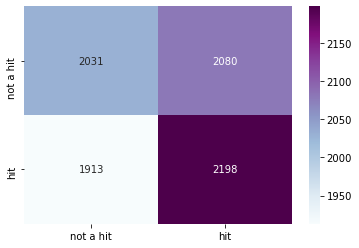

In [146]:
get_metrics(test_y, lr_preds)
get_cm(test_y, lr_preds)

# Logistic Regression with L1 (lasso) Regularization - l2 ridge is default

In [114]:
l1_lr_clf = LogisticRegression(penalty='l1', solver='liblinear')
l1_lr_clf.fit(train_X, train_y)

# Make predictions on the test data
lr_l1_preds = l1_lr_clf.predict(test_X)

Accuracy:  0.7195329603502797
Precision:  0.6863514350609127
Recall:  0.8085623935782048
F1:  0.742461469734197


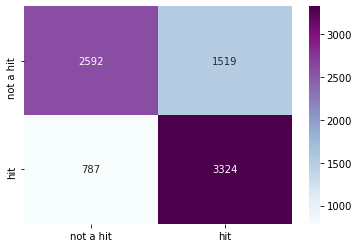

In [115]:
get_metrics(test_y, lr_l1_preds)
get_cm(test_y, lr_l1_preds)

Try scaling data - log reg usually needs scaling

In [116]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()  
scaler.fit(train_X)  

scaled_train_X = scaler.transform(train_X)  
scaled_test_X = scaler.transform(test_X)  

param_grid = {
    'C': np.logspace(-4, 4, 20)
}

lr_l1_clf = LogisticRegression(penalty='l1', solver='liblinear')

lr_grid_search = GridSearchCV(lr_l1_clf, param_grid, cv=5)
lr_grid_search.fit(scaled_train_X, train_y)

lr_preds = lr_grid_search.predict(scaled_test_X)

lr_grid_search.best_params_

{'C': 29.763514416313132}

Accuracy:  0.7205059596205303
Precision:  0.6881876686734482
Recall:  0.806373145220141
F1:  0.7426075268817203


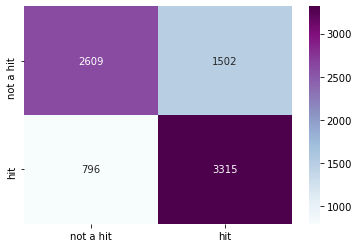

In [117]:
lr_grid_search.fit(scaled_train_X, train_y)

# Make predictions on the test data
lr_l1_preds = lr_grid_search.predict(scaled_test_X)

get_metrics(test_y, lr_l1_preds)
get_cm(test_y, lr_l1_preds)

Essentially the same as the empty lasso LR model

Beats the baseline logistic regression

# Naive Bayes

In [118]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

Accuracy:  0.5919484310386767
Precision:  0.5556537102473498
Recall:  0.9180248114813914
F1:  0.692286526644043


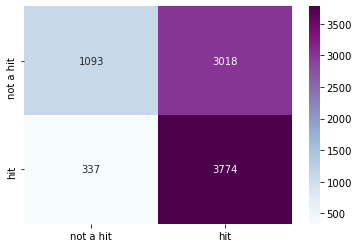

In [119]:
# empty model
nb_clf = GaussianNB()
nb_clf.fit(train_X, train_y)
nb_preds = nb_clf.predict(test_X)

get_metrics(test_y, nb_preds)
get_cm(test_y, nb_preds)

In [120]:
# parameter tuning
import numpy as np 

param_grid = {'var_smoothing': np.logspace(0,-9, num=100)} #https://www.kaggle.com/code/akshaysharma001/naive-bayes-with-hyperpameter-tuning#kln-196

# try scaling 
scaler = StandardScaler()  
scaler.fit(train_X)  

scaled_train_X = scaler.transform(train_X)  
scaled_test_X = scaler.transform(test_X)  

nb_clf = GaussianNB()

nb_grid_search = GridSearchCV(nb_clf, param_grid, cv=5)
nb_grid_search.fit(scaled_train_X, train_y)

nb_preds = nb_grid_search.predict(scaled_test_X)

nb_grid_search.best_params_

{'var_smoothing': 2.310129700083158e-05}

Accuracy:  0.7051812211140842
Precision:  0.6559437973747458
Recall:  0.8630503527122355
F1:  0.7453781512605043


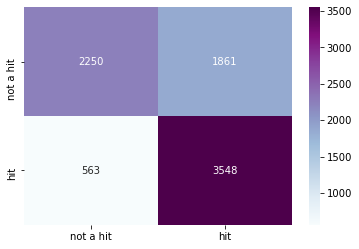

In [121]:
get_metrics(test_y, nb_preds)
get_cm(test_y, nb_preds)

in some metrics it is better (marginally)

# Decision Tree

In [122]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

Accuracy:  0.7126003405497446
Precision:  0.7137964774951077
Recall:  0.7098029676477743
F1:  0.7117941212342969


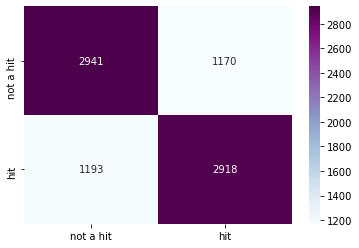

In [123]:
# empty model 
tree_clf = DecisionTreeClassifier()
tree_clf.fit(train_X, train_y)
tree_preds = tree_clf.predict(test_X)

get_metrics(test_y, tree_preds)
get_cm(test_y, tree_preds)

for computation sake, only test out a few params in the reasonable range of values

In [127]:
# parameter tuning
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [3, 5, 10, 20],
    'min_samples_leaf': [1, 2, 6 ],  # overfit with >10,
    'min_samples_split': [2, 4, 6] # overfit with >10,
}


tree_clf = DecisionTreeClassifier()

# perform the grid search using 5-fold cross validation
tree_grid_search = GridSearchCV(tree_clf, param_grid, cv=5)
tree_grid_search.fit(X, y)

tree_preds = tree_grid_search.predict(test_X)

tree_grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 6,
 'min_samples_split': 4}

Accuracy:  0.8024811481391388
Precision:  0.7499497487437186
Recall:  0.907565069326198
F1:  0.8212634822804313


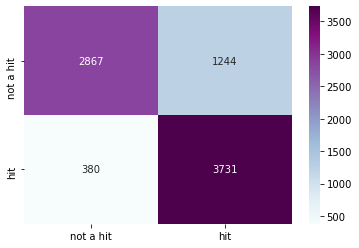

In [128]:
get_metrics(test_y, tree_preds)
get_cm(test_y, tree_preds)

New best 

# Random Forest 

In [129]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

Accuracy:  0.7949404037946971
Precision:  0.7683115733569373
Recall:  0.8445633665774751
F1:  0.8046349942062573


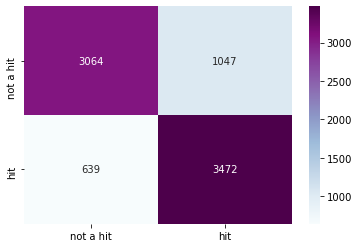

In [130]:
# empty model
rf_clf = RandomForestClassifier()
rf_clf.fit(train_X, train_y)
rf_preds = rf_clf.predict(test_X)

get_metrics(test_y, rf_preds)
get_cm(test_y, rf_preds)

In [131]:
# parameter tuning

# use same grid as for decision tree 
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [3, 5, 10, 20],
    'min_samples_leaf': [1, 2, 6 ],  # overfit with >10,
    'min_samples_split': [2, 4, 6] # overfit with >10,
}


rf_clf = RandomForestClassifier()

# perform the grid search using 5-fold cross validation
rf_grid_search = GridSearchCV(rf_clf, param_grid, cv=5)
rf_grid_search.fit(X, y)

rf_preds = rf_grid_search.predict(test_X)

rf_grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 6}

Accuracy:  0.943079542690343
Precision:  0.9014767467489531
Recall:  0.9948917538311847
F1:  0.9458834412580944


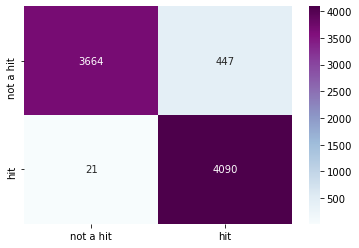

In [132]:
get_metrics(test_y, rf_preds)
get_cm(test_y, rf_preds)

by far the best performing model

# Neural Network

for testing out diff settings, params, num layers, optimizer, etc we just used trial and error, no algorithmic approach

# Pytorch

Followed this tutorial: https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89

Was clearer than the pytorch tutorial offered in class

In [133]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    

In [134]:
# scale data 
scaler = StandardScaler()
X_train = scaler.fit_transform(train_X)
X_test = scaler.transform(test_X)

# settings 
BATCH_SIZE = 64

In [135]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

In [136]:
train_data = TrainData(torch.Tensor(X_train), torch.Tensor(train_y.to_numpy()))
test_data = TestData(torch.FloatTensor(X_test))

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [137]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        
        # Number of input features is 14.
        self.layer_1 = nn.Linear(14, 10) 
        self.layer_2 = nn.Linear(10, 10)
        self.layer_3 = nn.Linear(10, 30)
        self.layer_4 = nn.Linear(30, 60)
        self.layer_5 = nn.Linear(60, 60)
        self.layer_6 = nn.Linear(60, 60)
        self.layer_out = nn.Linear(60, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.relu(self.layer_4(x))
        x = self.relu(self.layer_5(x))
        x = self.relu(self.layer_6(x))
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x


In [138]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LEARNING_RATE = 0.001

model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()

# adam is much better than SGD 
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)


BinaryClassification(
  (layer_1): Linear(in_features=14, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=30, bias=True)
  (layer_4): Linear(in_features=30, out_features=60, bias=True)
  (layer_5): Linear(in_features=60, out_features=60, bias=True)
  (layer_6): Linear(in_features=60, out_features=60, bias=True)
  (layer_out): Linear(in_features=60, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)


In [139]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

EPOCHS = 100 # 50

model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.54430 | Acc: 70.895
Epoch 002: | Loss: 0.49097 | Acc: 76.395
Epoch 003: | Loss: 0.48381 | Acc: 77.000
Epoch 004: | Loss: 0.47847 | Acc: 77.171
Epoch 005: | Loss: 0.47440 | Acc: 77.453
Epoch 006: | Loss: 0.46913 | Acc: 77.780
Epoch 007: | Loss: 0.46656 | Acc: 77.984
Epoch 008: | Loss: 0.46389 | Acc: 78.156
Epoch 009: | Loss: 0.46149 | Acc: 78.397
Epoch 010: | Loss: 0.45952 | Acc: 78.461
Epoch 011: | Loss: 0.45766 | Acc: 78.621
Epoch 012: | Loss: 0.45638 | Acc: 78.825
Epoch 013: | Loss: 0.45560 | Acc: 78.702
Epoch 014: | Loss: 0.45451 | Acc: 78.786
Epoch 015: | Loss: 0.45265 | Acc: 78.780
Epoch 016: | Loss: 0.45234 | Acc: 78.975
Epoch 017: | Loss: 0.45160 | Acc: 79.109
Epoch 018: | Loss: 0.45007 | Acc: 79.010
Epoch 019: | Loss: 0.45027 | Acc: 79.049
Epoch 020: | Loss: 0.44964 | Acc: 79.016
Epoch 021: | Loss: 0.44832 | Acc: 79.008
Epoch 022: | Loss: 0.44795 | Acc: 79.198
Epoch 023: | Loss: 0.44692 | Acc: 79.160
Epoch 024: | Loss: 0.44634 | Acc: 79.253
Epoch 025: | Los

In [140]:
nn_preds = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        nn_preds.append(y_pred_tag.cpu().numpy())

nn_preds = [a.squeeze().tolist() for a in nn_preds]


Accuracy:  0.7908051568961323
Precision:  0.7507866582756451
Recall:  0.8705910970566773
F1:  0.8062626717729219


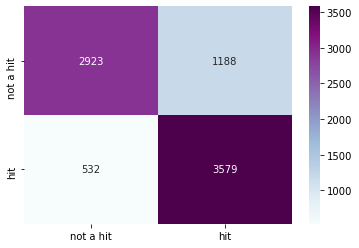

In [141]:
get_metrics(test_y, nn_preds)
get_cm(test_y, nn_preds)

# Results

In [147]:
results = pd.DataFrame()

model_preds = {'Logistic Regression - Baseline' : lr_preds
            , 'Lasso Logistic Regression' : lr_l1_preds
            , 'Naive Bayes': nb_preds
            , 'Decision Tree': tree_preds
            , 'Random Forest': rf_preds
            , 'Neural Net': nn_preds}

for model in model_preds.keys():

    preds = model_preds[model]

    results = results.append({'Model':model
                , 'Accuracy': accuracy_score(test_y, preds)
                , 'Precision': precision_score(test_y, preds)
                , 'Recall': recall_score(test_y, preds)
                , 'F1': f1_score(test_y, preds)}
                , ignore_index=True)

results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1']]

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression - Baseline,0.514352,0.513791,0.534663,0.524020
1,Lasso Logistic Regression,0.720506,0.688188,0.806373,0.742608
2,Naive Bayes,0.705181,0.655944,0.863050,0.745378
3,Decision Tree,0.802481,0.749950,0.907565,0.821263
4,Random Forest,0.943080,0.901477,0.994892,0.945883
5,Neural Net,0.790805,0.750787,0.870591,0.806263


Determine best by F1 score since it is harmonic mean of precision and recall and is therefore most reflective of the confusion matrixs

In [148]:
results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1']].sort_values(by=['F1'], ascending=False)

,Model,Accuracy,Precision,Recall,F1
4,Random Forest,0.943080,0.901477,0.994892,0.945883
3,Decision Tree,0.802481,0.749950,0.907565,0.821263
5,Neural Net,0.790805,0.750787,0.870591,0.806263
2,Naive Bayes,0.705181,0.655944,0.863050,0.745378
1,Lasso Logistic Regression,0.720506,0.688188,0.806373,0.742608
0,Logistic Regression - Baseline,0.514352,0.513791,0.534663,0.524020
